In [1]:
import random
import math
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import invgamma
from functools import partial
import statistics

In [10]:
def rw2(n):# this gives samples from weibull(2,1)# put n=40000,the shape 2 and the scale 1
    x,y=0,0
    distance=[]
    for i in range(1,n+1):
            r=random.weibullvariate(alpha,beta) # step size r
            theta=2.*math.pi*random.random()
            x +=r*math.cos(theta)
            y +=r*math.sin(theta)
            distance.append(r)# save the distances r for the mcmc sampler
    return(np.array(distance))# depending what do you want to do, either save the pairs, or save the distances r  between points
    #return(x,y)
    
alpha=1 # scale
beta=2 #shape parameter
n=50000
data = rw2(n)# very important because you need the same data, if you put rw2(n) in there you change the data every time
#data
#the best results I got with 50000,70000,stepsize 0.04

In [3]:
# calculate the log likelihood of weibull(a,b)
import scipy.stats 
from scipy.stats import dweibull
import numpy as np
from numpy import prod
def log_likelihood(x,b,a):# I switched a and b around
     return sum(dweibull.logpdf(x,scale=b,c=a))# c is shape
def likelihood(x,a_scale,b_shape):
     return prod(dweibull.pdf(x,scale=a_scale,c=b_shape))

In [31]:
import scipy.stats as stats
from scipy.stats import invgamma
# initial guess for theta(a and b) as array. Now the shape 2 is fixed, the prior is inverse gamma(1,2)
guess = 2# initial guess for scale
# Prepare storing MCMC chain as array of arrays.
A = [guess]
# define stepsize of MCMC.
stepsizes = 0.04 # array of stepsizes
accepted  = 0.0
old_theta=guess# define initial values for theta 
old_loglik = log_likelihood(data,old_theta,2)#calculate the first log likelihood
old_logtarget=old_loglik+invgamma.logpdf(old_theta,1,scale=2)
# Metropolis-Hastings with 10,000 iterations.
for p in range(70000):
    new_theta = old_theta + stats.norm(0, stepsizes).rvs() 
    #add the restraints on new_theta
    if new_theta<0: 
        continue
    new_loglik = log_likelihood(data,new_theta,2)
    new_logtarget=new_loglik+invgamma.logpdf(new_theta,1,scale=2)
    # Accept new candidate in Monte-Carlo fashing.
    if (new_logtarget > old_logtarget):
        A.append(new_theta)
        accepted = accepted + 1.0  # monitor acceptance
        old_loglik=new_loglik
        old_theta=new_theta
        old_logtarget=new_logtarget
    else:
        u = random.uniform(0.0,1.0)
        if (u < math.exp(new_logtarget-old_logtarget)):
            A.append(new_theta)
            accepted = accepted + 1.0  # monitor acceptance
            old_loglik=new_loglik
            old_theta=new_theta
            old_logtarget=new_logtarget 
print("Acceptance rate = "+str(accepted/10000.0))



Acceptance rate = 0.5056


1.0013104717
0.00223641070604


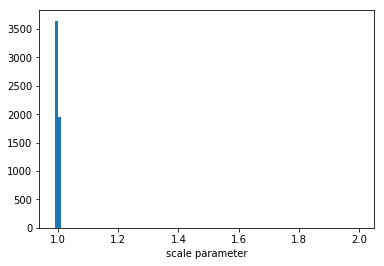

5626


In [30]:
#A=A[100:]# burn in if I do this the variance triples? why is that?
print(statistics.mean(A))
print(statistics.variance(A))
plt.hist(A,bins=100)
plt.xlabel("scale parameter")
#plt.xlim(0.9,1.1) 
plt.show()
print(len(A))

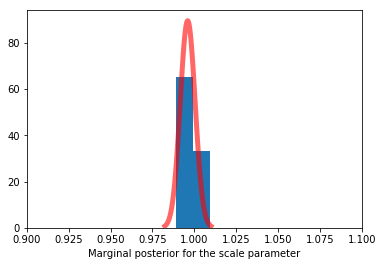

0.99612365848
1.98456437725e-05


In [32]:
a = 1+n
b=2+sum(data**2)
x = np.linspace(invgamma.ppf(0.001,a,scale=b),invgamma.ppf(0.999, a,scale=b),100)
plt.plot(x,invgamma.pdf(x,a,scale=b),'r-',lw=5, alpha=0.6, label='invgamma pdf')
plt.hist(A,bins=100,normed=True)
plt.xlabel("Marginal posterior for the scale parameter")
plt.xlim(0.9,1.1)
plt.show()
from scipy.stats import invgamma
print(invgamma.mean(a,scale=b))
print(invgamma.var(a,scale=b))
